# Learning best practices for model evaluation and hyperparameter tuning
En capitulos anteriores aprendimos los algoritmos esenciales para clasificacion y como mejorar nuestros datos antes de alimentar los algoritmos. Ahora es momento de aprender sobre las mejores practicas para construir buenos modelos de ML haciendo fine-tuning y que podamos evaluar la perfomance de nuestro modelo. En este capitulo veremos:
 • Assess the performance of machine learning models
 • Diagnose the common problems of machine learning algorithms
 • Fine-tune machine learning models
 • Evaluate predictive models using different performance metrics

## Streamlinin workflows with pipelines
Cuando aplicamos diferentes tecnicas de preprocesado en el capitulo 4, o PCA para comprension de datos en el capitulo 5, aprendimos que tenemos que re usaur los parameros que obteuvimos durante el fit. En esta seccion aprenderemos a usar la clase *pipeline* de scikit-learn. Nos permite entrenar un modelo incluyendo un numero arbitrario de pasos de transformaciones y aplicarlo para realizar predicciones en nueva data

### Loading the breas cancer winsoconsin dataset
Vamos a utilizar un data set de cancer de pecho, donde buscaremos ver si el tumar es maligno o beningno.

In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                   'machine-learning-databases'
 '/breast-cancer-wisconsin/wdbc.data',
                  header=None)

In [3]:
# Asignamos las 30 features a un array de numpy, y usamos el LabelEncoder object para poder transformar la clase (M y B) en integers
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
#Separamos el dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
      train_test_split(X, y,
                       test_size=0.20,
                       stratify=y,
                       random_state=1)

### Combining transformers and estimators in a pipeline
En el capitulo anterior aprendimos que muchos algoritmos de machine learning requieren input features en la misma escala para perfomance optimo. como el dataset de cancer tiene mediciones en distitnas escalas, debemos estandaraizar las columnas antes de alimentarlas al clasificador lineal. Ademas, supongamos que queremos comprimir nuestra data de las 30 dimensiones origianles en un subespacio de dos diensiones usando PCA

En vez de ir parte po parte, haremos una pipeline que haga todo

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
 
                         PCA(n_components=2),
 
                         LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


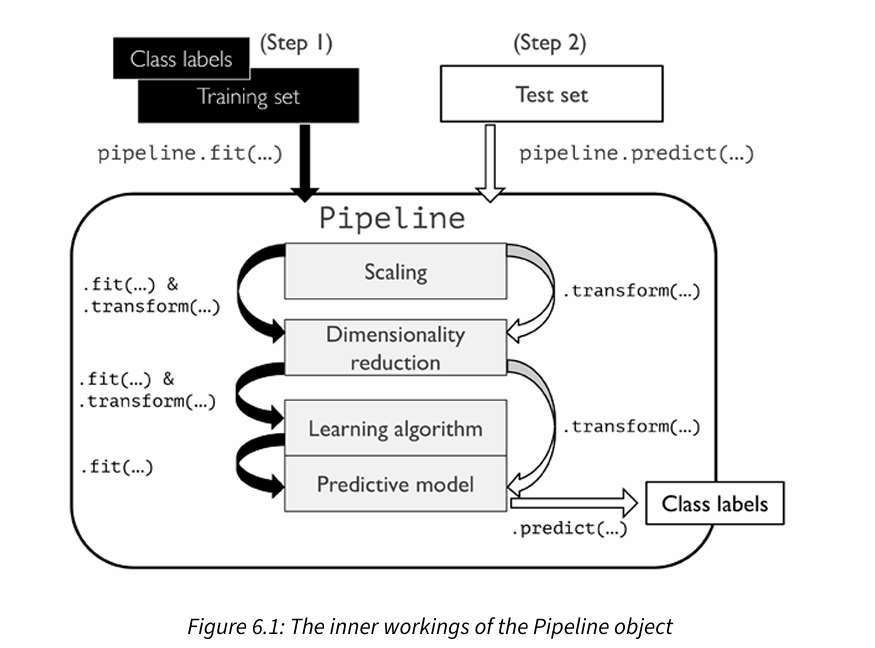

## Using k-fold cross-validation to assess model performance.
En esta seccion aprenderemos sobre cross-validation tecnoque llamada houldout cross-validation and k-fold cross validation, los cuales pueden ayudarnos a obtener estimados of the model generalization performance.

### The holdout method.
the holdout method es un metodo clasico y popularp ara estimar que tan bien generaliza un modelo de ML. El motodo consiste en separar el dataset inicial en test y train.

En el proceso de model selection buscamos encontrar los *parametros optimos* para tunear el modelo (los llamados *hyperparametros*). No es buena practica usar el modelo de *Test* para hacer la seleccion de modelo.

Una mejor manera de usar el metodo es separar la data en tres partes: train, validation y test. Donde el train se usa para hacer el fit de los diferentes modelos, y usamos el set de validacion para hacer la seleccion de modelo. De esta manera podemos ver de mejor manera que tan bien generaliza el modelo seleccionado.

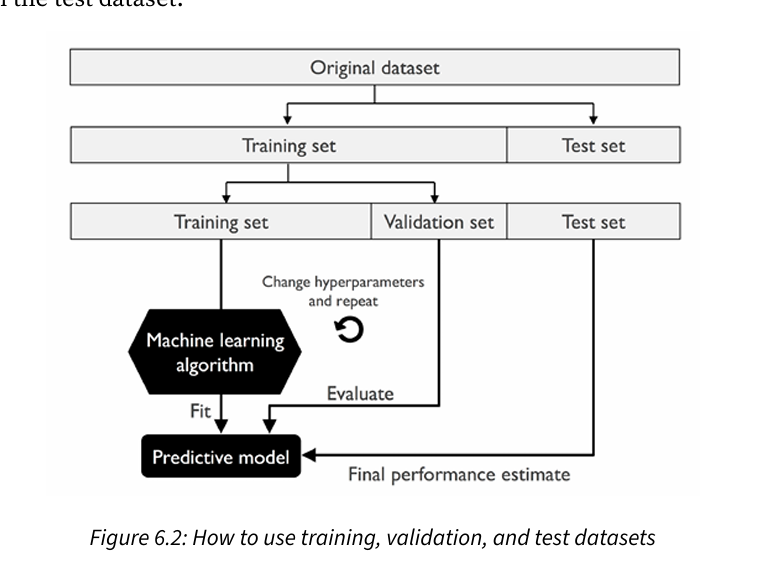

El problema de este metodo es que es muy sensible a la manera en la que particionamos los datos.

### K-fold cross-validation
En k-fold cross-validation, separamos de manera random el dataset de entramiento en k folds sin remplazar. En este caso $k-1$ folds son usados para el entrenaiento del modelo, y un fold es usado para el teste y evaluacion de rendimiento.

Luego calculamos el performance promedio de los modelos basados en los diferentes test independientes para obtener un estimativo del permofance que sea menos sensible a la sub-particion del training data. En general usamos esta tecnica para hacer tuning del modelo, es decir encontrar los mejores hiperparametros.

Una vez que encontramos los hyperparametros necesarios, podemos re entrenar el modelo en el dataset completo y obtener un estimativo final de perfomance. La razon para hacer esto, re entrenar en todo el dataset de test despues de hacer k-folds, es que estamos interesados en un modelo final en lugar de k individuals models.

Como k fold usa un resampling sin rempllazo, la ventaja que tiene esto es que en cada iteracion cada ejemplo se va a usar solo uan vez, por lo que siempre los datasets de prueba y test van a estar serapados.

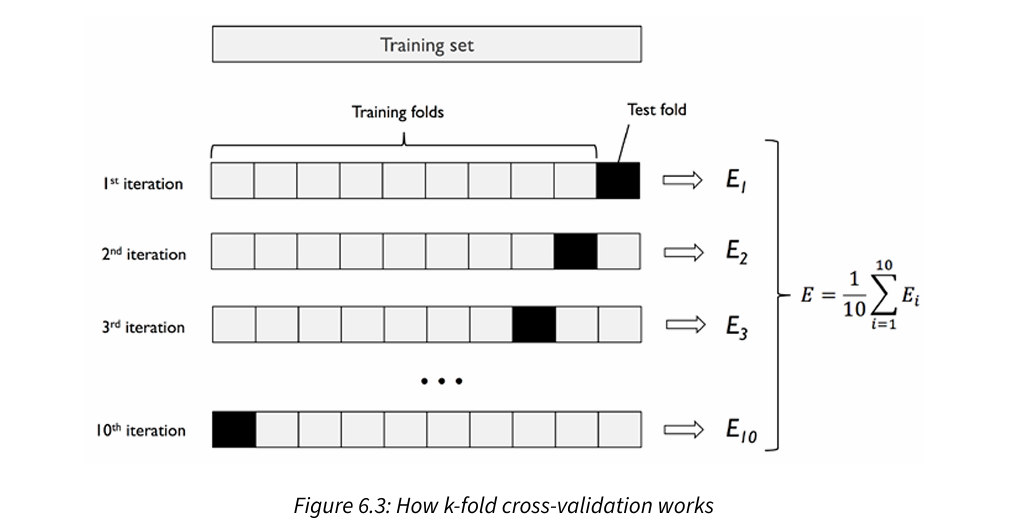

Otra varainte es el k-fold estratificado, el cual lo que hace ademas de hace ademas del k-fold mantiene la propocion de las clases.

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
      pipe_lr.fit(X_train[train], y_train[train])
      score = pipe_lr.score(X_train[test], y_train[test])
      scores.append(score)
      print(f'Fold: {k+1:02d}, '
            f'Class distr.: {np.bincount(y_train[train])}, '
            f'Acc.: {score:.3f}')

mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           n_jobs=1)
print(f'CV accuracy scores: {scores}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


## Debuggin algorithms with learning and validation curves
En esta seccion veremos a dos herramientas de diagnostico que nos pueden ayudar a mejorar la perfomance de nuestro algoritmos: **curvas de aprendizaje** y **curvas de validacion**. En las siguients secciones discutiremos como usar las curvas para diagnosticar los problemas que se puedan presentar.

### Diagnosing bias and variance problemas with learning curves
Si un modelo es muy complejo para el dataset de entrenamineto, por ejemplo un arbol de desicion muy profundo, el modelo luego no podra generalizar a nueva data.

Graficando la accuracy del los dataset de entramineto y vdalicion podemos detecatar si el modelo sufre de mucha varianza o bias.

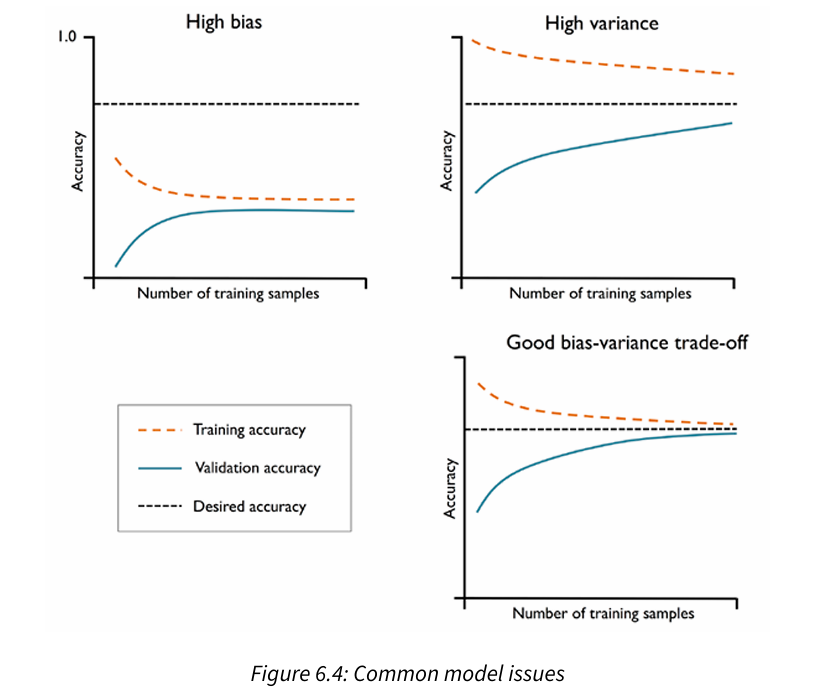

(0.8, 1.03)

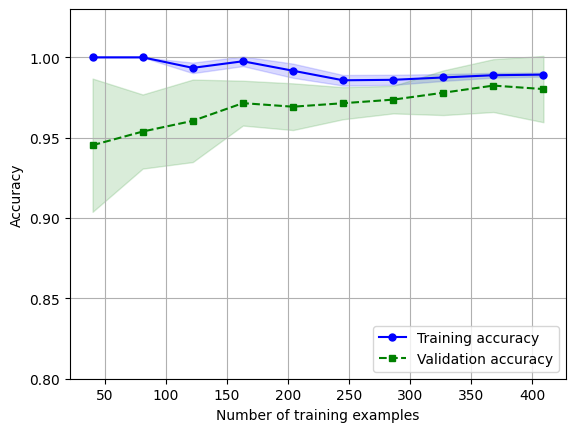

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',max_iter=10000))

train_sizes, train_scores, test_scores = \
                            learning_curve(estimator=pipe_lr,
                                           X=X_train,
                                           y =y_train,
                                           train_sizes=np.linspace(0.1,1.0,10),
                                           cv=10,
                                           n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
 
          color='blue', marker='o',
 
          markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
 
                  train_mean + train_std,
 
 
                  train_mean - train_std,
                  alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
 
          color='green', linestyle='--',
 
 
          marker='s', markersize=5,
          label='Validation accuracy')
plt.fill_between(train_sizes,
 
                  test_mean + test_std,
 
 
                  test_mean - test_std,
                  alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])

### Addressing over and underfitting with validtion curves
Las curvas de validacion son una herramienta muy util para mejorar el rendimento de nuestro modelo permitiendonos ver cosas como underfitting o underfitting.

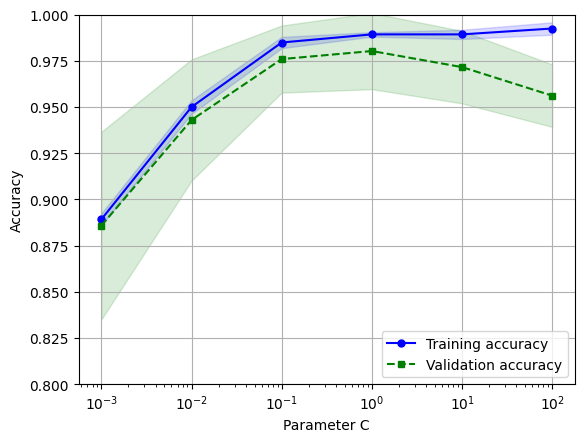

In [13]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
 
                             estimator=pipe_lr,
 
 
 
 
 
                             X=X_train,
                             y=y_train,
                             param_name='logisticregression__C',
                             param_range=param_range,
                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
 
          color='blue', marker='o',
 
          markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
 
                  train_mean - train_std, alpha=0.15,
 
                  color='blue')
plt.plot(param_range, test_mean,
 
          color='green', linestyle='--',
 
 
          marker='s', markersize=5,
          label='Validation accuracy')
plt.fill_between(param_range,
 
                  test_mean + test_std,
 
 
                  test_mean - test_std,
                  alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

## Fine-tuning machine learning models via grid search
En ML existen dos tipos de parametros, los que se aprenden de entrenar el modelo, por ejemplo los pesos de una regresion logstica y los parametros de un algoritmos de aprendizaje que son optimizados de manera separada. Estos ultimso son los que se conoce como hyperparametros de un modelo, por ejemplo el parametro de regularizacion en una regresion logistica o la profundidad maxima de un arbol de desicion.

En partes capitulos pasados, vimos como usar las curvas de validacion y aprendizaje para diagnosticar nuestro modelo. En esta seccion usaremos una tecnica para optimizar la eleccion de hyperparametros llamada *grid search*.

### Tuning hyperparameter via grid search
El aproach del grid search es bastante simple, funciona a forma de fuerza bruta buscando todo un paradigma de valores hasta hallar la combinacion optima

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),
                          SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1,
                 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
                 'svc__kernel': ['linear']},
                {'svc__C': param_range,
                 'svc__gamma': param_range,
                 'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    refit=True,
                    n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])


In [16]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.974


### Exploring hyperparameter configurations mode widely with random grid search
El problema con grid serach normal es que:
- La busqueuda esta limitada a la lista de hyperparametros que nostoros se nos ocurra
- Es computancionalmente muy costoso al incrementar la cnatidad de posibles busquedas

En este contexto es que nace el random grid search

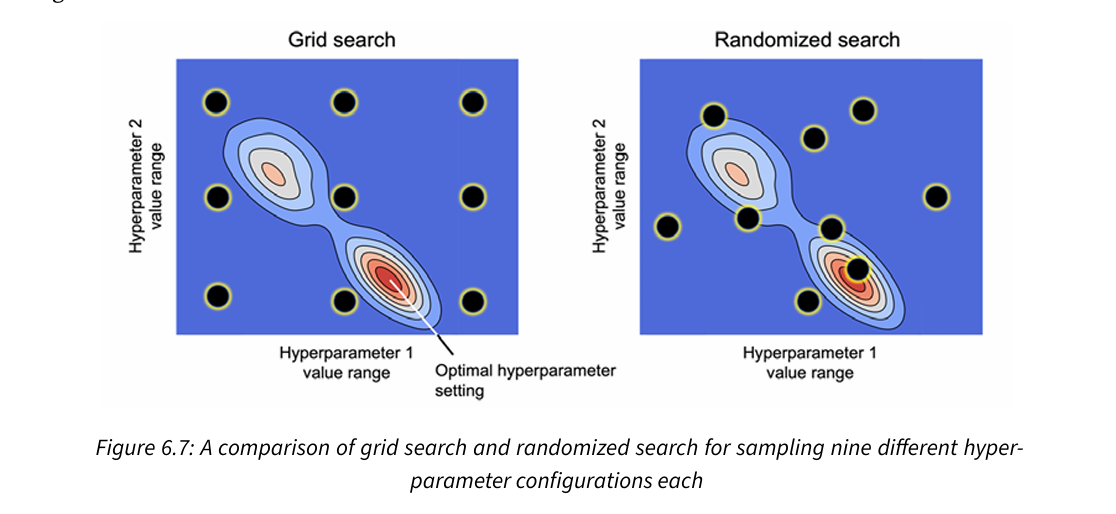

In [25]:
import scipy
# Rango para GS
param_range = [0.0001, 0.001, 0.01, 0.1,
                1.0, 10.0, 100.0, 1000.0]

#Rango para RGS, el cual usa distribuciones.
param_range = scipy.stats.loguniform(0.0001, 1000.0)

In [26]:
param_range

In [27]:
from sklearn.model_selection import RandomizedSearchCV
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_grid = [{'svc__C': param_range,
                 'svc__kernel': ['linear']},
                {'svc__C': param_range,
                 'svc__gamma': param_range,
                 'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc,
                          param_distributions=param_grid,
                          scoring='accuracy',
                          refit=True,
                          n_iter=20,
                          cv=10,
                          random_state=1,
                          n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)

0.9780676328502416


### More resource-efficent hyperparameter search with succesive halving
Tomando la idea de randomized search, scikit-learna implement una variatne "halving", *HalvingRandomSearchCV*, que hace que la busqueda de hyperparametros sea mucho mas eficiente. Halving correctamente, dado un largo pool de candidatos, tira de manera efectiva hyperparametros poco prometedores hasta que solo quede una. El proceso por el cual ocurre es el siguiente:
 1. Draw a large set of candidate configurations via random sampling
 2. Train the models with limited resources, for example, a small subset of the training data (as opposed to using the entire training set)
 3. Discard the bottom 50 percent based on predictive performance
 4. Go back to step 2 with an increased amount of available resources

Estos pasos se repiten hasta que solo una configuracion de hyperparametros queda.

In [28]:
# en sckilit learn 1.0 HalvinRandomSearchSV sigue siendo experimental, por lo que hay que activarlo primero
from sklearn.experimental import enable_halving_search_cv

In [30]:
from sklearn.model_selection import HalvingRandomSearchCV
hs = HalvingRandomSearchCV(pipe_svc,
                             param_distributions=param_grid,
                             n_candidates='exhaust',
                             resource='n_samples',
                             factor=1.5,            #Candidatos eliminados en cada itearcion
                             random_state=1,
                             n_jobs=-1)

## Diferntes metricas de evaluacion
En esta seccion veremos las diferentes metricas que podemos ver para evaluar el rendimineto de un algoritmos de ML

### Confusion matrix

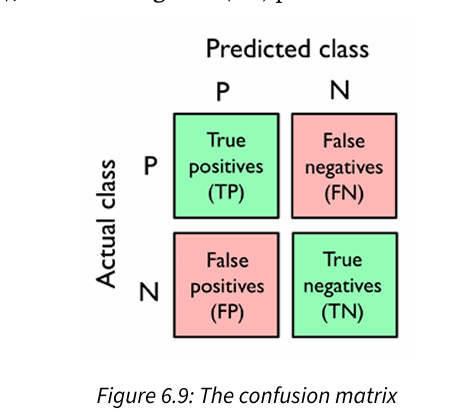

La matriz de confusion busca mostrar en problemas de clasificacion los falsos negativos y los falsos positivos.

In [31]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[71  1]
 [ 2 40]]


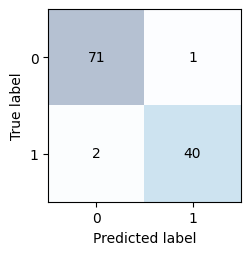

In [32]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
      for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j],
                  va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Optimizando la presicion y el reacall de un modelo de clasificacion
Tanto el error como la presicion dan una informacion general de cuantos ejempos son mal clasificados. En error puede ser entendido ocmo la suma de todas las predicciones falsas dividido por el numero total de prediccion, y la presicion como la suma de las predicciones correctas dividido el numero total de predicciones:

$$
ERR = \frac{FP+FN}{FP+FN+TP+TN}
$$

$$
ACC = \frac{TP+TN}{FP+FN+TP+TN} = 1- ERR
$$

Tambien existen los ratios *true positive* y *false positive* como metricas de perfomance para clases que estan altamente imbalanceada:

$$
FPR = \frac{FP}{FP+TN}
$$

$$
TPR = \frac{TN}{FN+TP}
$$

En diagnosis de tumar, por ejemplo, estamos mas preocupados por la dateccion de tumores malignos para poder ayudar al pacient. Sin emberta, tambien es importante no clasificar mal los tumores beningnos como malignos para no asustar a los clientes de manera innecesaria. 

Una forma de balancear esto es optimizar la media armonica del PRE y el REC, el llamado $F1$ scoe:

$$
F1 = 2\frac{PRE \times REC}{PRE + REC}
$$

In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

Precision: 0.976
Recall: 0.952
F1: 0.964


### Plotting a receiver operating characteristic
**Receiver operating characteristic (ROC)** son una herramienta muy buena para seleccionar modelos de clasificacion basados en sus rendimiento con repsecto a FPR y TPR, los cuales se computan moviendo el parametro de corte del algoritmos. La diagonal de una curva de ROC puede interpresarte como "adivinar", los modelos que can por debajo se consideran que es peor que adivinar. Un clasificador perfecto caeria en la punta superior izquierda con un TPR de 1 y un FPR de 0. Basado en la curva ROC, podemos computar la llamda **ROC area under the curve** para caracterizar el perfomance de un modelo de clasificacion.

De manera similar, podemos computar las curvas de **precision-recall** para diferentes cortes de probabilidad de un clasificador.

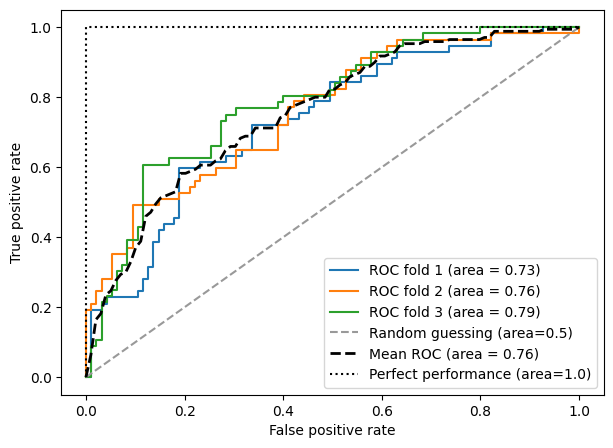

In [34]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
pipe_lr = make_pipeline(
      StandardScaler(),
      PCA(n_components=2),
      LogisticRegression(penalty='l2', random_state=1,
                         solver='lbfgs', C=100.0)
  )
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
 
     probas = pipe_lr.fit(
 
 
 
 
 
 
 
         X_train2[train],
         y_train[train]
     ).predict_proba(X_train2[test])
     fpr, tpr, thresholds = roc_curve(y_train[test],
                                      probas[:, 
1],
                                      pos_label=1)
     mean_tpr += interp(mean_fpr, fpr, tpr)
 
 
 

 
     mean_tpr[0] = 0.0
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr,
              tpr,
              label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1],
 
          [0, 

 1],
          linestyle='--',
 
 
          color=(0.6, 0.6, 0.6),
          label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
 
          label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
 
          [0, 

 1, 1],
          linestyle=':',
 
 
          color='black',
          label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

### Scoring metrics for multiclass clasificacion
Las metricas de esocre que discutimos hasta ahora son especificar para clasificacion binaria, sin embargo con scikit learn es posible extende esto a probkemas multiclase mediante el OvA clasificacacion. El micro-promedia se calcula como los TPs,TNs,FPs y FNs del sistema. Por ejemplo el micro-averge de presicion en un contexto de k-clases se calcula como:

$$
PRE_{micro} = \frac{TP_{1}+..+TP_{k}}{TP_{1}+..TP_{k}+FP_{1}+..+FP_{k}}
$$

Mientras que el macro se calcula como

$$
PRE_{macro} = \frac{PRE_{1}+...+PRE_{k}}{k}
$$

El micro averge es util si queremos pesar la instancia de cada prediccion de manera igual, mientras que el macro averge le da el mismo pesos a todas las clases.

### Dealing with class imabalance
